A file to assess the fit of each model to the participant data, across the three hierarchy levels

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib.transforms as transforms
import matplotlib
import pandas as pd
import os
import os.path
from scipy.optimize import curve_fit

In [13]:
dname = os.path.dirname(os.getcwd()) + '/data_loading/data_v2_quotes/'
dname

'c:\\Users\\Jirko\\Desktop\\Hip_Lab\\analysis_scripts/data_loading/data_v2_quotes/'

In [14]:
ACCURACY = np.load(dname + 'ACCURACY_New.npy')
acc_first_prop = np.load(dname + 'Acc_first_prop_New.npy')
acc_second_prop = np.load(dname + 'acc_second_prop_New.npy')
acc_third_prop = np.load(dname + 'acc_third_prop_New.npy')

In [15]:
print(acc_first_prop[0,0,:])
acc_first_prop_reshaped = np.reshape(acc_first_prop,(49,128))
acc_second_prop_reshaped = np.reshape(acc_second_prop,(49,128))
acc_third_prop_reshaped = np.reshape(acc_third_prop,(49,128))

[1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.]


In [16]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def linear(x, w, b):
    y = x * w + b
    return y

def relu(x, w, b1, b2):
    y = np.maximum((x * w - b1),0) + b2
    return y

def heaviside(x, b1, b2):
    y = 1 * (x + b1 > 0) * b2
    return y

def linear_step_func(x, x0, x1):
    y= np.piecewise(x, [
        x < x0, 
       (x >= x0) & (x <= x1), 
        x > x1],
            [0., 
            lambda x: x/(x1-x0)+x0/(x0-x1),
            1.])
    return y

Now we write a function to asses the fit for each model and return the distribution of log-likelihoods

In [23]:
def asses_fit(function_list, level_data_list, levels_list):

     fit_dict = {
               "sigmoid": np.full((level_data_list[0].shape[0],3), np.nan), 
               "linear": np.full((level_data_list[0].shape[0],3), np.nan),
               "relu": np.full((level_data_list[0].shape[0],3), np.nan),
               "linear_step_2": np.full((level_data_list[0].shape[0],3), np.nan)
               }

     model_file_list = ["sigmoid", "linear", "relu", "linear_step_2"]

     x_data = np.linspace(1, level_data_list[0].shape[1], level_data_list[0].shape[1])
     
     # loop over each model
     for i, function in enumerate(function_list):

          # loop over each level in the hierarchy
          for j, level in enumerate(levels_list):

               # load the model params for each participant
               df = pd.read_csv(os.getcwd() + "/params_trialwise/" + level + "/" + model_file_list[i] + ".csv")
               # convert to a numpy array
               all_popt = df.to_numpy()[:,1:]

               # make an empty array to store the results for this model across the three levels
               # difference_results = np.full((level_data_list[0].shape[0], len(function_list)), np.nan)

               # loop over the participants
               for k in range(level_data_list[0].shape[0]):
                    
                    # participant outputs
                    y_data = level_data_list[j][k,:]
                    # our model predictions from previous fit
                    y_pred = function(x_data, *all_popt[k,:])
                    # fit_dict[model_file_list[i]][k, j] = np.linalg.norm(y_data-y_pred)
                    # take the mean log likelihood for each participant constant for numerical stability
                    fit_dict[model_file_list[i]][k, j] = np.mean(-np.log(np.absolute(y_data-y_pred) +1e-10))
     
     return fit_dict
               


In [24]:
function_list = [sigmoid, linear, relu, linear_step_func]
level_data_list = [acc_first_prop_reshaped, acc_second_prop_reshaped, acc_third_prop_reshaped]
levels_list = ["first", "second", "third"]
fit_dict = asses_fit(function_list, level_data_list, levels_list)

Save this to our data frame

In [25]:
fit_dict_to_save = {}
for key in fit_dict:
    fit_dict_to_save[key] = np.sum(fit_dict[key], axis=1) / 3
pd.DataFrame.from_dict(fit_dict_to_save).to_csv("params_trialwise/participantwise_log_likelihood_2.csv")

Lets have a look at how things look, we take the mean fit across all three levels for each model

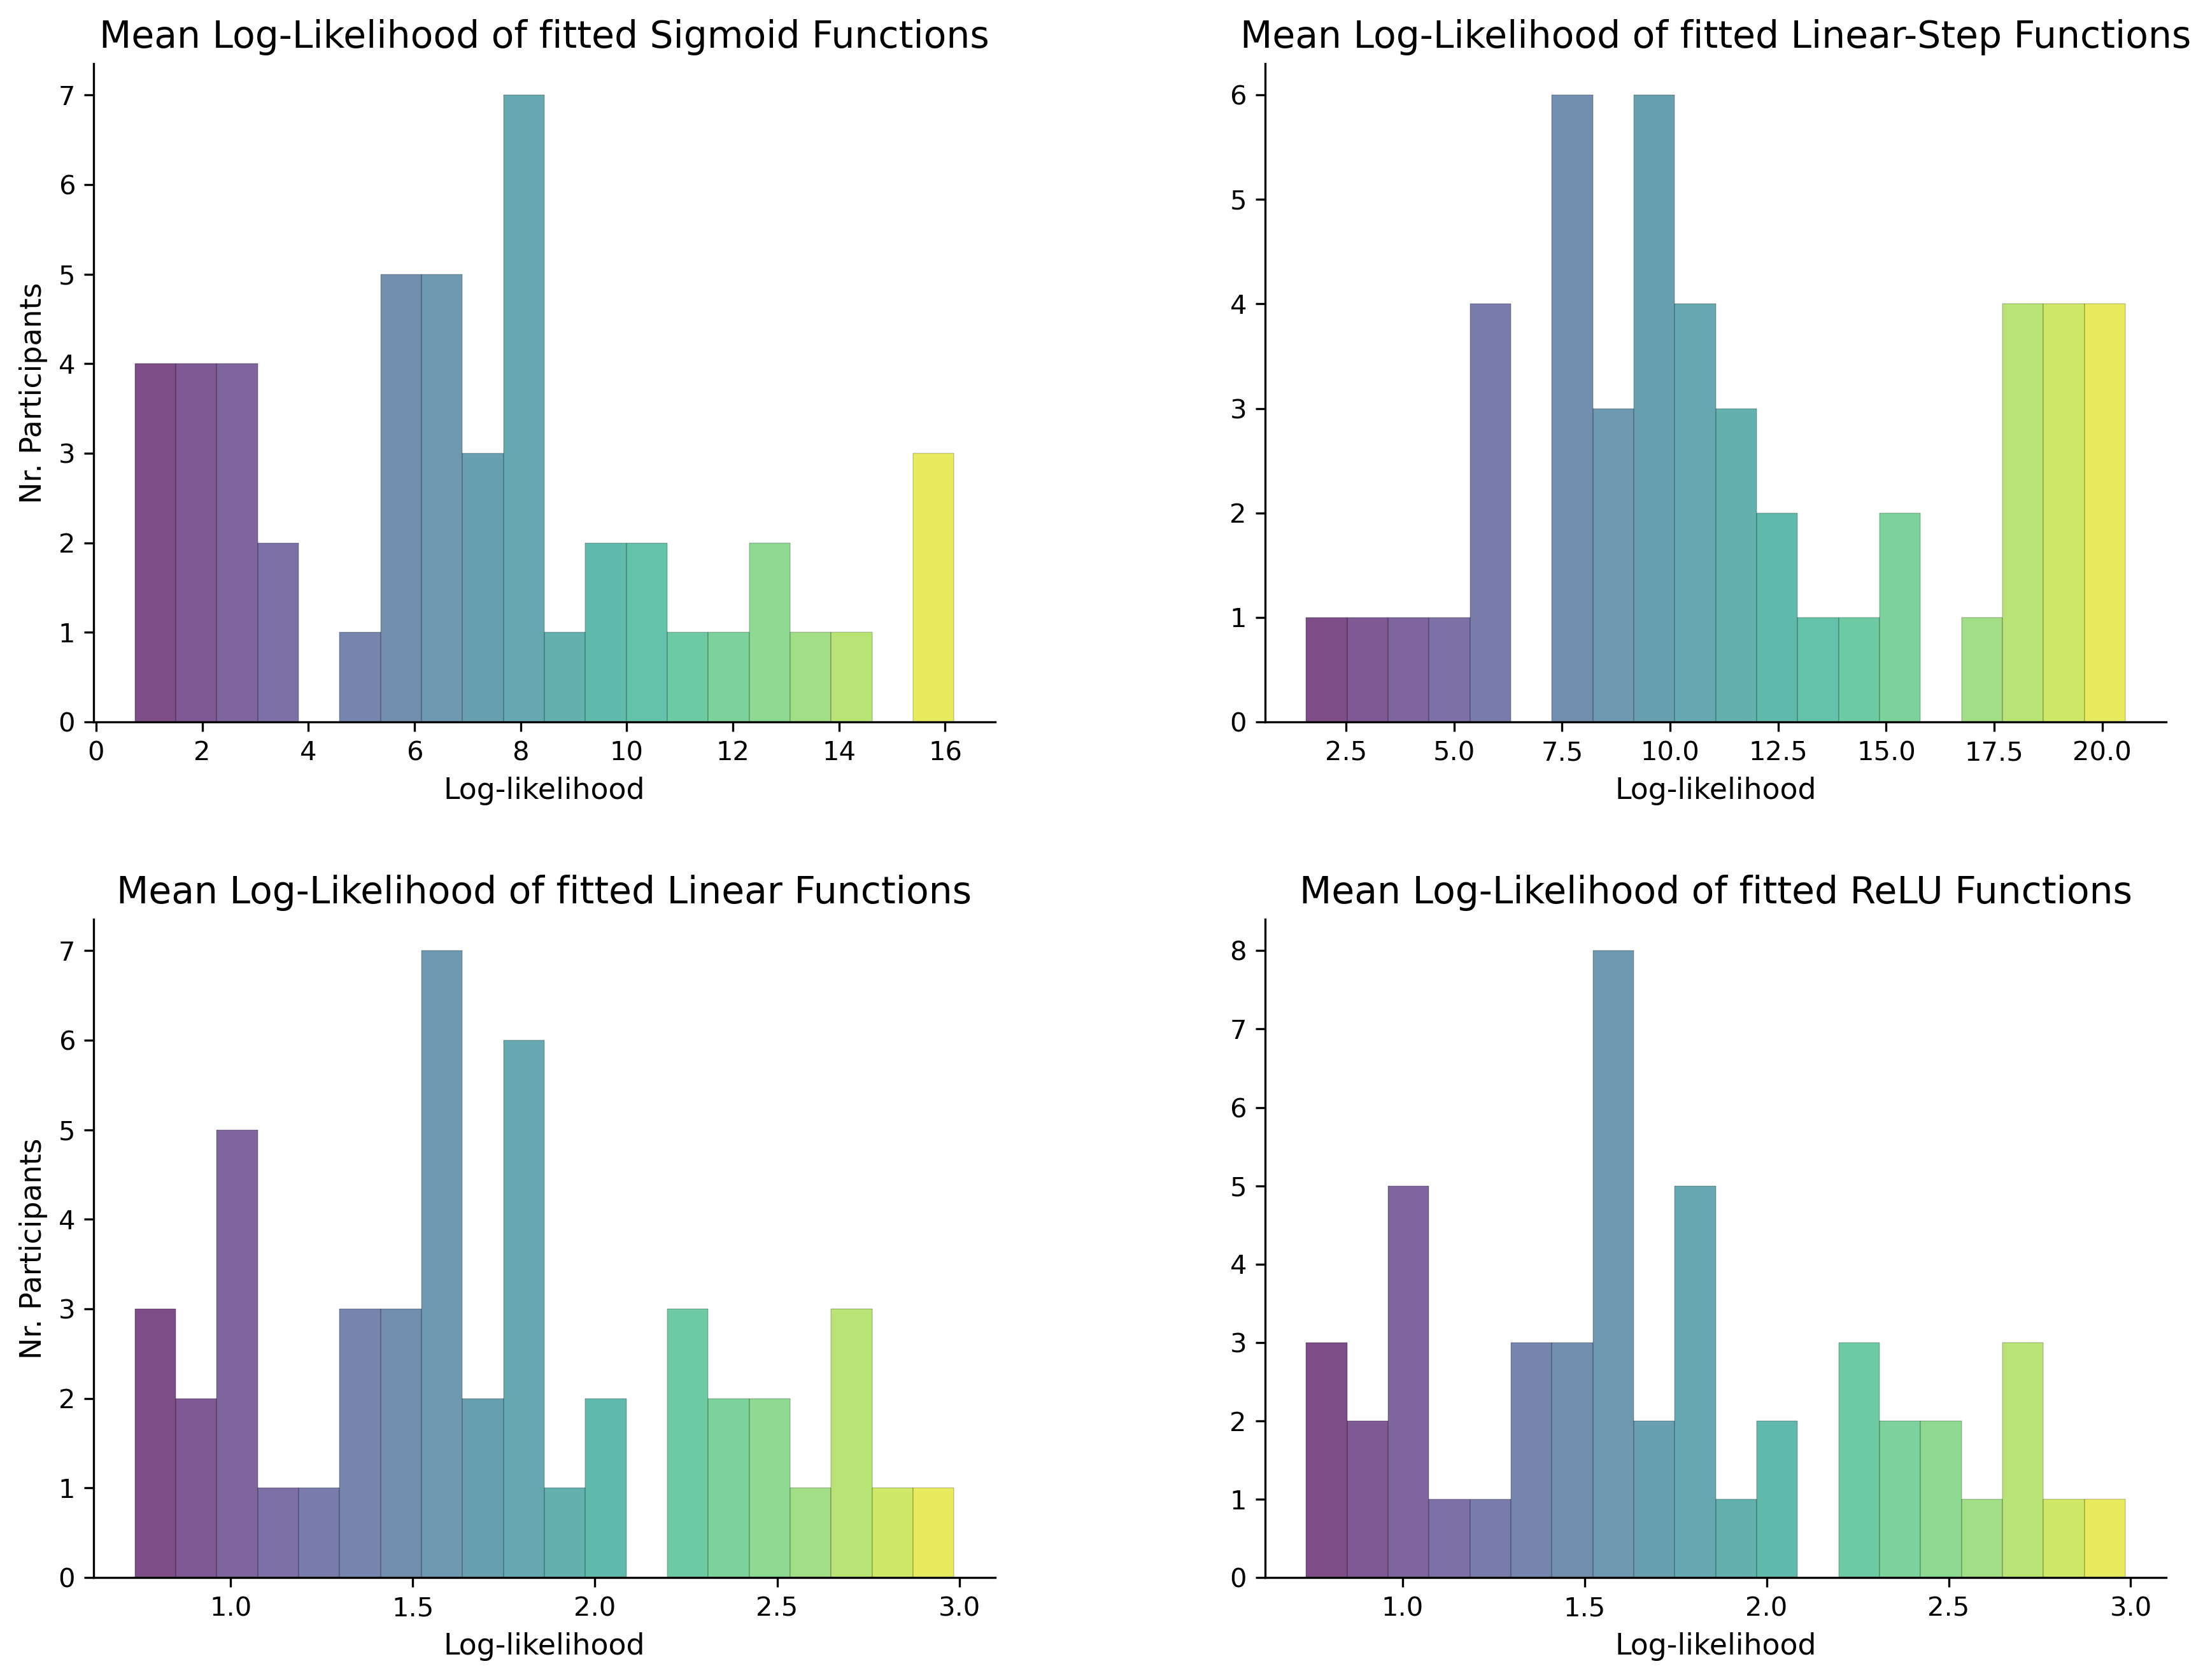

In [26]:
# code for plotting our histograms
def plot_hists(titles, data_dict, keys):
    sig_data = np.sum(fit_dict["sigmoid"], axis=1)/3

    # code for hist from
    fig, axes = plt.subplots(2, 2, figsize=(14, 10.5), dpi=300, facecolor='w')
    for i, ax in enumerate(axes.flatten()):

        n, bins, patches = ax.hist(data_dict[keys[i]], 
                                    bins=20, 
                                    facecolor='#2ab0ff', 
                                    edgecolor='black', 
                                    linewidth=.1, 
                                    alpha=0.7)

        n = n.astype('int') # it MUST be integer

        # Good old loop. Choose colormap of your taste
        for j in range(len(patches)):
            patches[j].set_facecolor(plt.cm.viridis(j/len(n)))

        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

        # set the title
        ax.set_title('Mean Log-Likelihood of fitted %s Functions' % titles[i], fontsize=14)

        # make the x and y labels
        ax.set_xlabel('Log-likelihood', fontsize=11)
        if i in (0, 2):
            ax.set_ylabel('Nr. Participants', fontsize=11)
    
    plt.subplots_adjust(
                    wspace=0.3, 
                    hspace=0.3)

    # plt.savefig(os.getcwd() + "/log-likelihood_plots/All.svg")
    plt.show()

titles = ["Sigmoid", "Linear-Step", "Linear", "ReLU"]
keys = ["sigmoid", "linear_step_2", "linear", "relu"]
plot_hists(titles, fit_dict_to_save, keys)

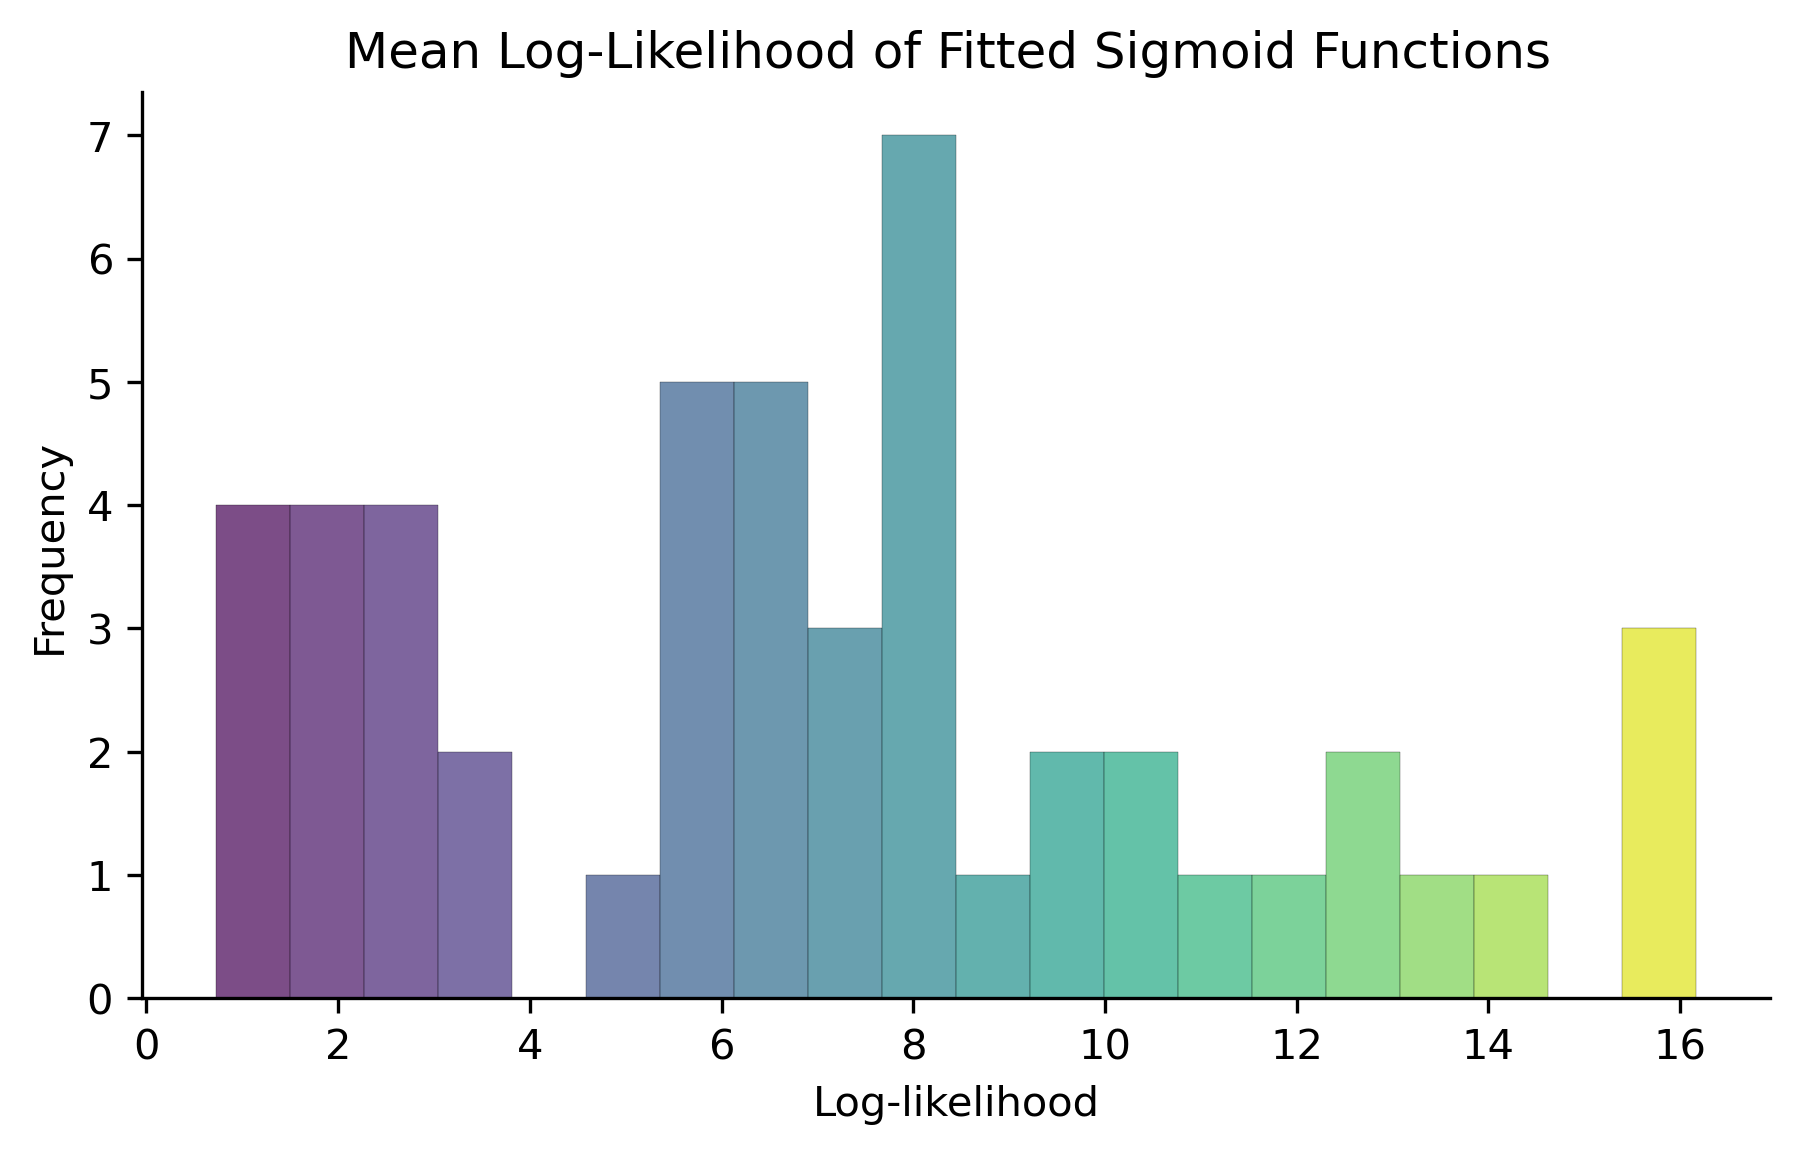

In [10]:
sig_data = np.sum(fit_dict["sigmoid"], axis=1)/3

# code for hist from
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300, facecolor='w')

n, bins, patches = ax.hist(sig_data, bins=20, facecolor='#2ab0ff', edgecolor='black', linewidth=0.1, alpha=0.7)

n = n.astype('int') # it MUST be integer

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(i/len(n)))


# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Add title and labels with custom font sizes
plt.title('Mean Log-Likelihood of Fitted Sigmoid Functions ', fontsize=12)
plt.xlabel('Log-likelihood', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
# plt.savefig(os.getcwd() + "/log-likelihood_plots/Sigmoid.png")
plt.show()

1.7312144672226992

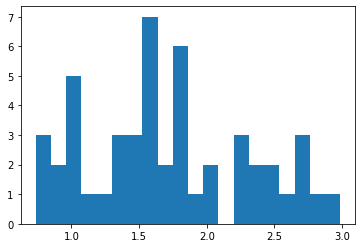

In [53]:
linear_data = np.sum(fit_dict["linear"], axis=1)/3
# linear_data = fit_dict["linear"][:,0]
plt.hist(linear_data, 20)
np.mean(linear_data)

(array([3., 2., 5., 1., 1., 3., 3., 8., 2., 5., 1., 2., 0., 3., 2., 2., 1.,
        3., 1., 1.]),
 array([0.73584104, 0.84830692, 0.9607728 , 1.07323868, 1.18570456,
        1.29817044, 1.41063632, 1.5231022 , 1.63556808, 1.74803396,
        1.86049984, 1.97296572, 2.0854316 , 2.19789748, 2.31036336,
        2.42282924, 2.53529512, 2.647761  , 2.76022688, 2.87269276,
        2.98515864]),
 <BarContainer object of 20 artists>)

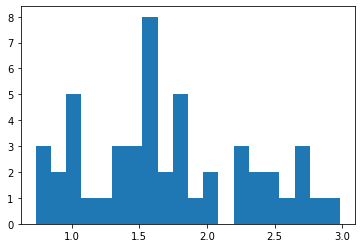

In [61]:
relu_data = np.sum(fit_dict["relu"], axis=1)/3
plt.hist(relu_data, 20)
# np.mean(relu_data)

17.038101748356276

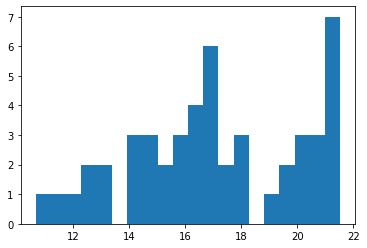

In [55]:
linear_step_data = np.sum(fit_dict["linear_step"], axis=1)/3
plt.hist(linear_step_data, 20)
np.mean(linear_step_data)

[11.79024707  7.04853101  1.73121447  1.72937152]
[5.1385752  4.20068198 0.59751514 0.59808538]


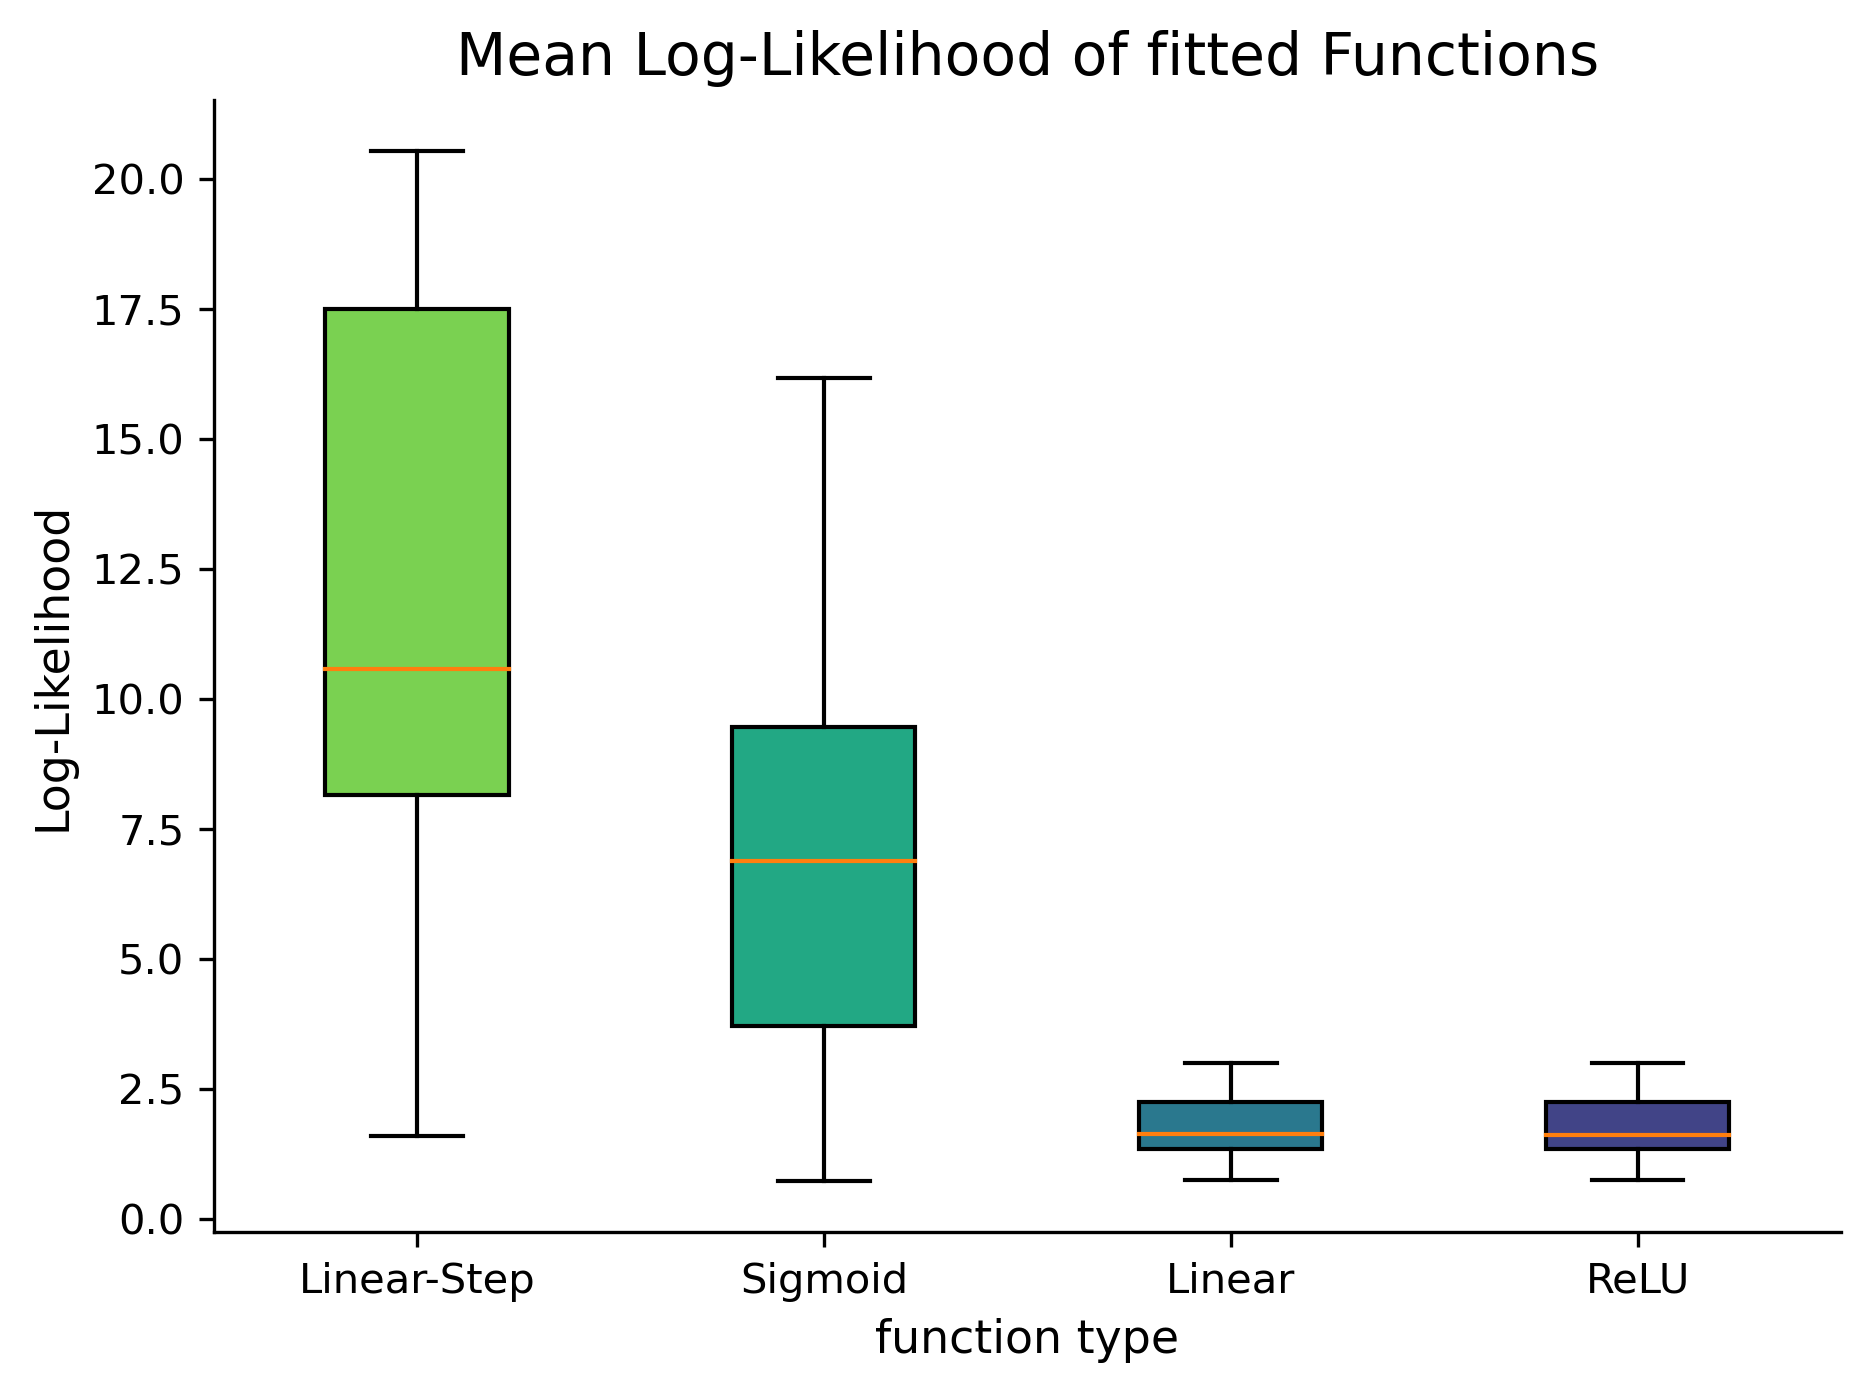

In [28]:
# code for plotting our histograms
def plot_boxplot(labels, data_dict, keys):
    sig_data = np.sum(fit_dict["sigmoid"], axis=1)/3

    # code for hist from
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300, facecolor='w')

    # make data all in one plot
    all_data = np.full((49,4), np.nan)
    for i, key in enumerate(keys):
        all_data[:,i] = data_dict[key]
    print(np.mean(all_data, axis=0))
    print(np.std(all_data, axis=0))
    bplot = ax.boxplot(all_data,
                vert=True,  # vertical box alignment
                patch_artist=True,  # fill with color
                labels=labels)  # will be used to label x-ticks)

    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # set the title
    ax.set_title('Mean Log-Likelihood of fitted Functions', fontsize=14)

    # make the x and y labels
    ax.set_xlabel('function type', fontsize=11)
    ax.set_ylabel('Log-Likelihood', fontsize=11)

    # fill with colors
    colors = [plt.cm.viridis(.8), plt.cm.viridis(.6), plt.cm.viridis(.4), plt.cm.viridis(.2)]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.savefig(os.getcwd() + "/log-likelihood_plots/All_boxplot_2.png")
    plt.show()

labels = ["Linear-Step","Sigmoid","Linear", "ReLU"]
keys = ["linear_step_2","sigmoid", "linear", "relu"]
plot_boxplot(labels, fit_dict_to_save, keys)